## Preprocessing

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import os

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
# to check if tensorflow is using gpu or not
len(tf.config.list_physical_devices('GPU')) > 0

True

Understanding Provided Data

In [12]:
# os.getcwd()
patient_data = pd.read_csv('Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv',names=['pid','disease'])

In [15]:
# printing patient id and disease info
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [27]:
# knowing the audio text files
df = pd.read_csv("Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/203_1p4_Tc_mc_AKGC417L.txt",sep='\t',names=['start','end','crackles','wheezes'])
df.head()

,start,end,crackles,wheezes
0,0.685,2.208,0,0
1,2.208,4.577,1,0
2,4.577,6.970,1,0
3,6.970,9.351,0,0
4,9.351,11.851,0,0


The annotation text files have four columns:
- Beginning of respiratory cycle(s)
- End of respiratory cycle(s)
- Presence/absence of crackles (presence=1, absence=0)
- Presence/absence of wheezes (presence=1, absence=0)

We can extract info from the file names also as:
Each audio file name is divided into 5 elements, separated with underscores (_).

1. Patient number (101,102,...,226)
2. Recording index
3. Chest location 

      a. Trachea (Tc)

      b. Anterior left (Al)

      c. Anterior right (Ar)

      d. Posterior left (Pl)

      e. Posterior right (Pr)

      f. Lateral left (Ll)

      g. Lateral right (Lr)

4. Acquisition mode 

     a. sequential/single channel (sc), 

     b. simultaneous/multichannel (mc)

5. Recording equipment 

     a. AKG C417L Microphone (AKGC417L), 

     b. 3M Littmann Classic II SE Stethoscope (LittC2SE), 

     c. 3M Litmmann 3200 Electronic Stethoscope (Litt3200), 
     
     d.  WelchAllyn Meditron Master Elite Electronic Stethoscope (Meditron)

In [28]:
# taking the file names
import os
path='Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200']

In [29]:
def getFilenameInfo(file):
    return file.split('_')

In [30]:
getFilenameInfo('101_1b1_Al_sc_Meditron')

['101', '1b1', 'Al', 'sc', 'Meditron']

In [33]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','wheezes'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,wheezes,pid,mode,filename
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron


Join Patient Data with our Files DataFrame

In [34]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [35]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


Jo join based on pid, we need to make the datatype of pid in both the files same.

In [36]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

Finally, we can merge to create our data

In [37]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,wheezes,pid,mode,filename,disease
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI


Saving our output in csv format

In [38]:
os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

We only want that parts from whole audio file which contains Respiratory Cycles.

We will utilize the start and end time specified for these cycles in our data dataframe

In [48]:
'''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    by default librosa gives sr=22050
'''
def getPureSample(raw_data,start,end,sr):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

We multiplied start/end with sampling rate cause start is time and raw_data is array sampled according to sampling rate
Now we also want our input images to our cnn to be of same size for that audio files must be of same length i.e (start - end) must be same

We will find the best length we can have

<AxesSubplot: ylabel='pid'>

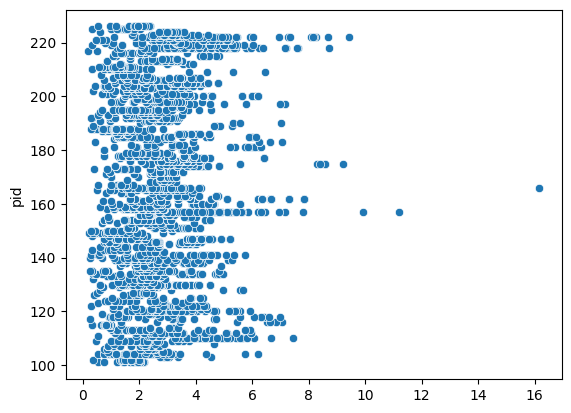

In [40]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

<AxesSubplot: >

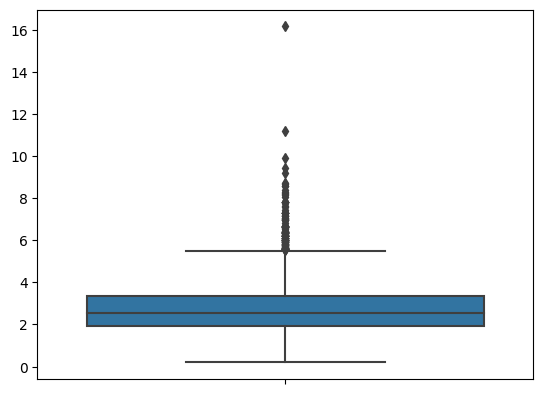

In [41]:
sns.boxplot(y=(data.end-data.start))

A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile [Q1], median, third quartile [Q3] and “maximum”).

From these plots we can conclude that best length is ~6
Also if difference is <6 we must Zero Pad it to get it to required length.

Zero-padding refers to the process of symmetrically adding zeroes to the input matrix. It's a commonly used modification that allows the size of the input to be adjusted to our requirement.

Here zero padding would mean silence.

In [42]:
# directory to store our processed audio files
os.makedirs('processed_audio_files')

A single sample of audio file can have Many Respiratory Cycles so we might have same multiple files for a single audio file

We will be using Librosa module for loading audio files and Soundfile module for writing to output path

Librosa - A python package for music and audio analysis. Librosa also normalizes the audio array.

Soundfile - The soundfile module is an audio library based on libsndfile, CFFI and NumPy. It can read and write sound files. 

In [50]:
# how single data looks in our dataframe
import librosa as lb
for index,row in data.iterrows():
    print("Index:",index)
    print("DataRow:\n",row)
    audio_file_loc=path + row['filename'] + '.wav'
    audioArr,sampleRate=lb.load(audio_file_loc)
    print("sr:",sampleRate)
    break

Index: 0
DataRow:
 start                        0.036
end                          0.579
crackles                         0
wheezes                          0
pid                            101
mode                            sc
filename    101_1b1_Al_sc_Meditron
disease                       URTI
Name: 0, dtype: object
sr: 22050


In [51]:
import soundfile as sf

i,cnt = 0,0

for index,row in data.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    #If len > maxLen , change len to maxLen
    if end-start>maxLen:
        end=start+maxLen  # end - start = maxLen
    
    audio_file_loc=path + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path='processed_audio_files/' + filename
    cnt+=1
    
    # librosa also normalizes the audio array
    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ', cnt)

C:\Users\Aditya Bapat\AppData\Local\Temp\ipykernel_10684\1838716462.py:34: FutureWarning: Pass size=132300 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  padded_data = lb.util.pad_center(pureSample, reqLen)


Total Files Processed:  6898
